In [ ]:
%matplotlib inline
import matplotlib
import pandas as pd
import glob
import ortools
import docplex.mp.model as mp
import math
import pandas as pd

import random
import string

In [2]:
def make_df(folder_name):
    path =r'./data/VMware_dataton_case/' + folder_name # use your path
    allFiles = glob.glob(path + "/*.csv")
    frame = pd.DataFrame()
    list_ = []
    for num, file_ in enumerate(allFiles):
        h = None
        if num == 0:
            h = 0
        df = pd.read_csv(file_,index_col=None, header=h)
        list_.append(df)
    frame = pd.concat(list_[1:])
    frame.columns = list_[0].columns
    return frame

In [3]:
perf_stats = make_df('zf_perf_stats_10min.csv')
power_stats = make_df('zf_power_stats.csv')
vm = make_df('zf_vm.csv')

In [4]:
perf_stats.head()

entity_id     entity_type  metric_value  \
0  42160e13-98f3-53cd-5503-8974d76bcaa4  VirtualMachine  1.731258e+03   
1  42162735-e79a-40b4-d282-19b3824807a5  VirtualMachine  2.666667e-01   
2  42119cb2-932c-159d-3391-8cc030407dd1  VirtualMachine  7.500000e-02   
3  4216dde4-7286-efda-5cd9-3afb95a75c55  VirtualMachine  7.725119e+06   
4  42166c56-4458-9346-447a-67be00cb8735  VirtualMachine  2.824700e+06   

                          metric_name aggregation_type  aggregation_period  \
0          mem.usage.absolute.percent              avg                 600   
1   net.usage.rate.kiloBytesPerSecond              avg                 600   
2  disk.usage.rate.kiloBytesPerSecond              avg                 600   
3          sys.uptime.absolute.second              avg                 600   
4          sys.uptime.absolute.second              avg                 600   

   collected_time  
0      1480463400  
1      1480465800  
2      1480464600  
3      1480466400  
4      1480464600

df2.head()

In [5]:
power_stats.head()

id  \
0  4c4c4544-0038-4210-8030-c6c04f383432|null|2016...   
1  4c4c4544-0053-5310-8031-c8c04f383432|null|2016...   
2  4c4c4544-0053-5310-8031-c7c04f383432|null|2016...   
3  4c4c4544-0056-4d10-8032-c3c04f383432|null|2016...   
4  4c4c4544-0044-5110-8032-c8c04f383432|null|2016...   

                                esx__fk  collected_time  bmc_reading  
0  4c4c4544-0038-4210-8030-c6c04f383432      1480358780        188.0  
1  4c4c4544-0053-5310-8031-c8c04f383432      1480362640        144.0  
2  4c4c4544-0053-5310-8031-c7c04f383432      1480358720        124.0  
3  4c4c4544-0056-4d10-8032-c3c04f383432      1480358780        104.0  
4  4c4c4544-0044-5110-8032-c8c04f383432      1480358720        108.0

In [6]:
vm.head()

id power_state  arrival_ts  arrival_day  \
0  42243d34-20f6-ab80-81e8-11df964ad54b   poweredOn  1480584081   1480550400   
1  4211880c-9402-6eb5-488a-79013bffd2c5   poweredOn  1480584081   1480550400   
2  42114201-fde4-77bd-673f-9312f7566757   poweredOn  1480584081   1480550400   
3  4224e3e5-9f99-7d09-81b2-04ec04363d58   poweredOn  1480584081   1480550400   
4  42118288-df9c-e366-2999-1c276fabf18c   poweredOn  1480584081   1480550400   

                                esx__fk  
0  4c4c4544-0056-4d10-8032-c2c04f383432  
1  4c4c4544-0056-4d10-8032-b5c04f383432  
2  4c4c4544-0056-4d10-8032-b5c04f383432  
3  4c4c4544-0035-4210-8030-c2c04f383432  
4  4c4c4544-0053-5310-8031-c8c04f383432

In [7]:
time_span_days =(perf_stats['collected_time'].max() - perf_stats['collected_time'].min())/60/60/24
time_span_days

3

In [8]:
hosts = perf_stats[perf_stats['entity_type'] == 'HostSystem']
vms = perf_stats[perf_stats['entity_type'] == 'VirtualMachine']

In [9]:
vms.head()

entity_id     entity_type  metric_value  \
0  42160e13-98f3-53cd-5503-8974d76bcaa4  VirtualMachine  1.731258e+03   
1  42162735-e79a-40b4-d282-19b3824807a5  VirtualMachine  2.666667e-01   
2  42119cb2-932c-159d-3391-8cc030407dd1  VirtualMachine  7.500000e-02   
3  4216dde4-7286-efda-5cd9-3afb95a75c55  VirtualMachine  7.725119e+06   
4  42166c56-4458-9346-447a-67be00cb8735  VirtualMachine  2.824700e+06   

                          metric_name aggregation_type  aggregation_period  \
0          mem.usage.absolute.percent              avg                 600   
1   net.usage.rate.kiloBytesPerSecond              avg                 600   
2  disk.usage.rate.kiloBytesPerSecond              avg                 600   
3          sys.uptime.absolute.second              avg                 600   
4          sys.uptime.absolute.second              avg                 600   

   collected_time  
0      1480463400  
1      1480465800  
2      1480464600  
3      1480466400  
4      1480464600

In [10]:
hosts.head()

entity_id entity_type  metric_value  \
63  4c4c4544-0044-5110-8032-c7c04f383432  HostSystem  8.451017e+06   
64  38383135-3735-5a43-3331-3432584d364a  HostSystem  2.154333e+02   
65  4c4c4544-0053-5310-8031-c4c04f383432  HostSystem  3.851700e+03   
66  4c4c4544-0053-5310-8031-c4c04f383432  HostSystem  1.177247e+07   
67  4c4c4544-0036-3110-8054-c7c04f4a5931  HostSystem  1.108933e+03   

                           metric_name aggregation_type  aggregation_period  \
63          sys.uptime.absolute.second              avg                 600   
64   net.usage.rate.kiloBytesPerSecond              avg                 600   
65          mem.usage.absolute.percent              avg                 600   
66       mem.active.absolute.kiloBytes              avg                 600   
67  disk.usage.rate.kiloBytesPerSecond              avg                 600   

    collected_time  
63      1480480200  
64      1480480800  
65      1480480800  
66      1480480800  
67      1480479000

In [11]:
vms_g = vms.groupby(['entity_id'])

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


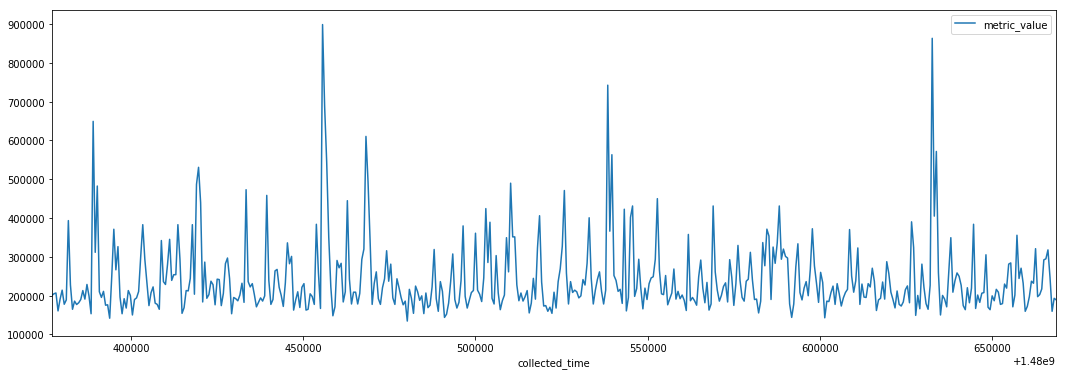

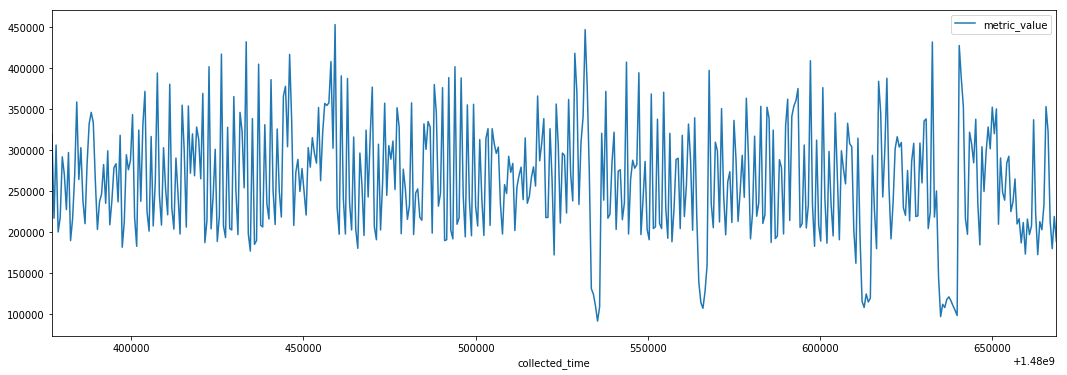

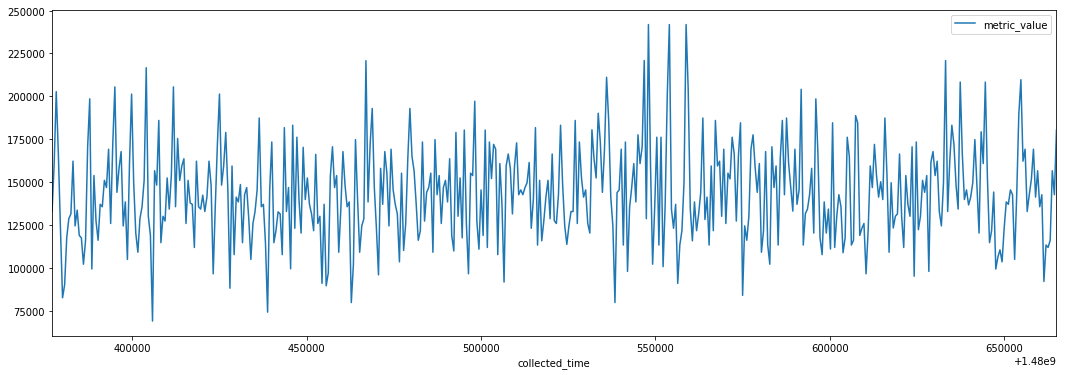

In [12]:
%pylab inline
pylab.rcParams['figure.figsize'] = (18, 6)
for index, (name, group) in enumerate(vms_g):
    group[group['metric_name'] == 'mem.active.absolute.kiloBytes'].sort_values('collected_time').plot(x= 'collected_time', y='metric_value')
    if index > 1:
        break

In [13]:
hosts[hosts['metric_name'] == 'mem.active.absolute.kiloBytes']['metric_value'].mean()/1000/1000

15.321749300627051

In [14]:
vm_memory = vms[vms['metric_name'] == 'mem.active.absolute.kiloBytes'].sort_values('collected_time')

In [15]:
vm_memory.head()

entity_id     entity_type  metric_value  \
4660   421cd40b-35de-a7c9-2a71-3964b34f84e0  VirtualMachine  3.050385e+05   
14273  4216c08e-bdae-a35f-06bf-0f437d47cf84  VirtualMachine  2.579495e+06   
9715   421cf118-1e2a-4ae0-cbe9-c79526418fc7  VirtualMachine  4.026524e+05   
14412  42162788-d12c-6f5a-e8b4-b6c6d00818b4  VirtualMachine  5.387028e+05   
8037   42162788-d12c-6f5a-e8b4-b6c6d00818b4  VirtualMachine  5.856285e+05   

                         metric_name aggregation_type  aggregation_period  \
4660   mem.active.absolute.kiloBytes              avg                 600   
14273  mem.active.absolute.kiloBytes              avg                 600   
9715   mem.active.absolute.kiloBytes              avg                 600   
14412  mem.active.absolute.kiloBytes              avg                 600   
8037   mem.active.absolute.kiloBytes              avg                 600   

       collected_time  
4660       1480372800  
14273      1480372800  
9715       1480372800  
14412      1480372800  
8037       1480373400

In [16]:
vm_demand = vm_memory[['entity_id', 'metric_value', 'collected_time'] ]

In [17]:
vm_demand.head()

entity_id  metric_value  collected_time
4660   421cd40b-35de-a7c9-2a71-3964b34f84e0  3.050385e+05      1480372800
14273  4216c08e-bdae-a35f-06bf-0f437d47cf84  2.579495e+06      1480372800
9715   421cf118-1e2a-4ae0-cbe9-c79526418fc7  4.026524e+05      1480372800
14412  42162788-d12c-6f5a-e8b4-b6c6d00818b4  5.387028e+05      1480372800
8037   42162788-d12c-6f5a-e8b4-b6c6d00818b4  5.856285e+05      1480373400

In [18]:
vm_demand_g = vm_demand.groupby(['entity_id'])

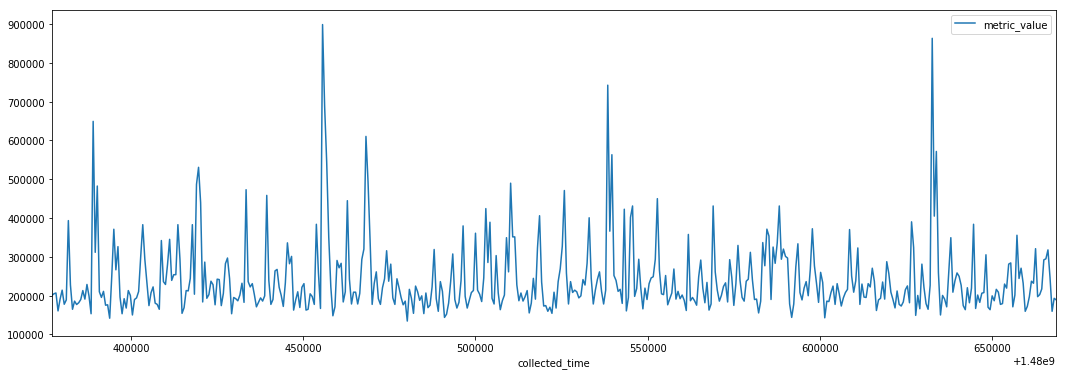

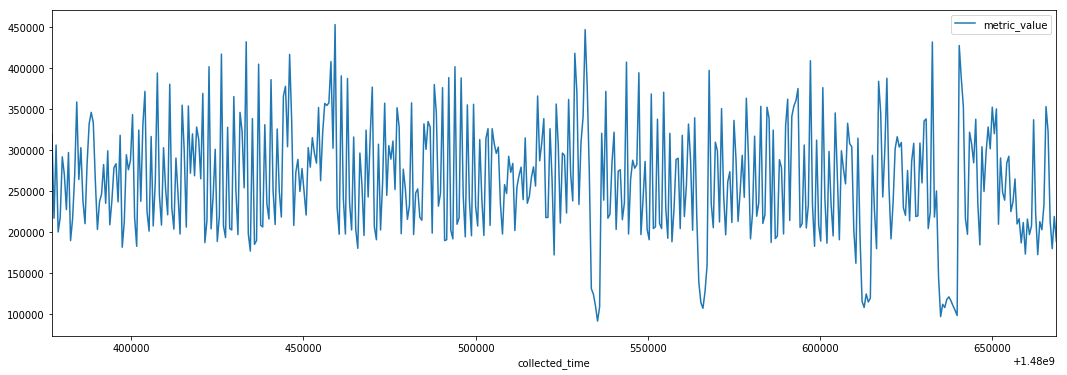

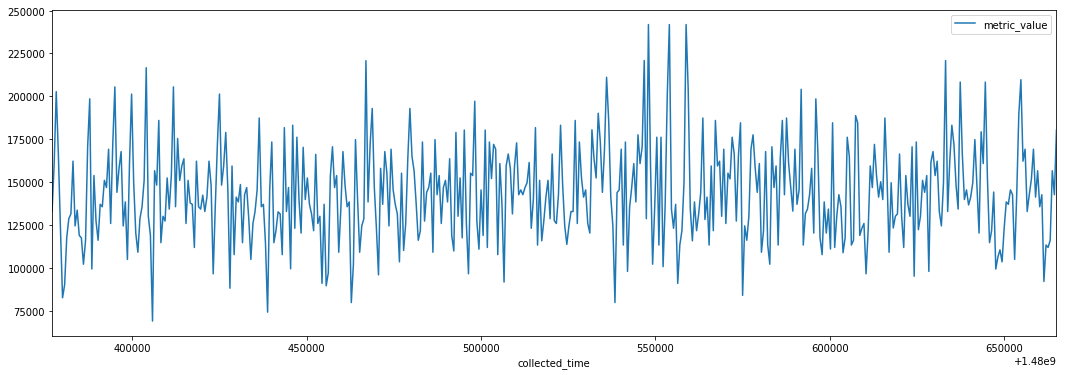

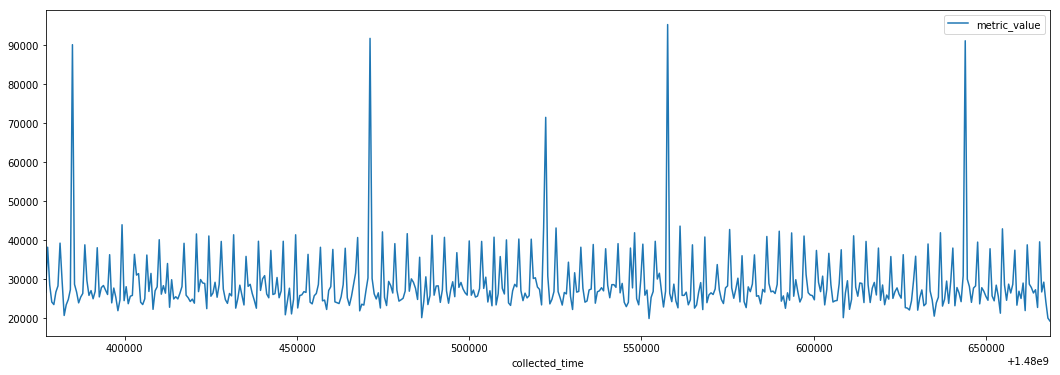

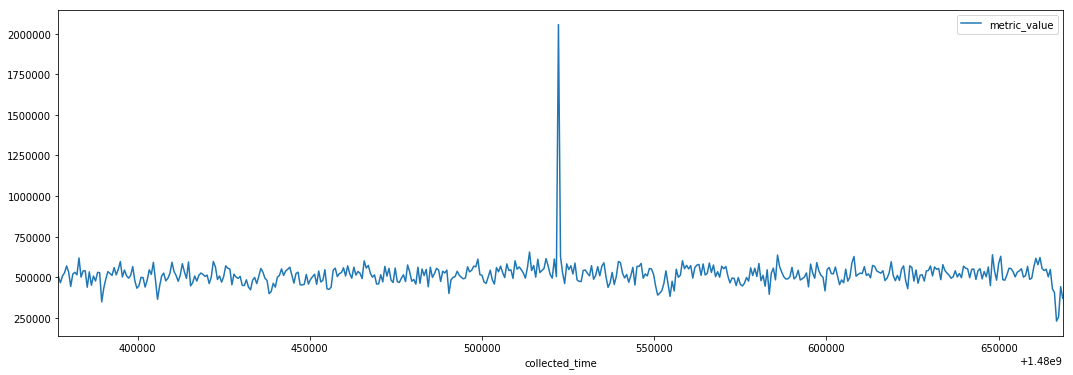

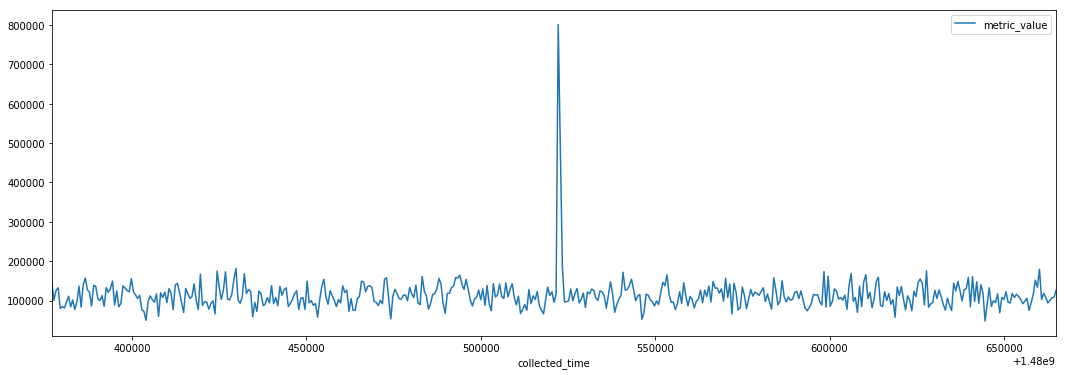

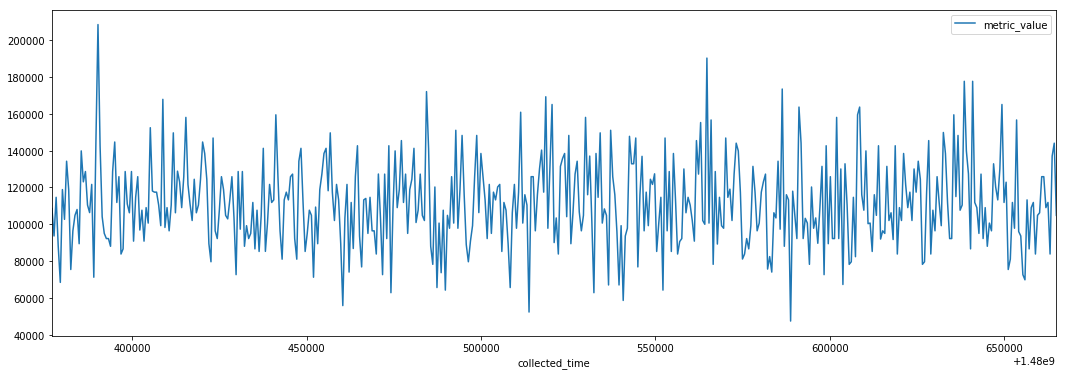

In [19]:
vm_demand_sample = []
for index, (name, group) in enumerate(vm_demand_g):
    group.sort_values('collected_time').plot(x= 'collected_time', y='metric_value')
    vm_demand_sample.append(group)
    if index > 5:
        break

In [20]:
vm_demand_sample[0]

entity_id   metric_value  collected_time
1486   4200ef3d-f8fa-5ab3-3e8f-4b18a1ade8e8  200066.400000      1480377000
12141  4200ef3d-f8fa-5ab3-3e8f-4b18a1ade8e8  204469.866667      1480377600
13004  4200ef3d-f8fa-5ab3-3e8f-4b18a1ade8e8  206567.066667      1480378200
19014  4200ef3d-f8fa-5ab3-3e8f-4b18a1ade8e8  160430.000000      1480378800
1885   4200ef3d-f8fa-5ab3-3e8f-4b18a1ade8e8  190838.266667      1480379400
7723   4200ef3d-f8fa-5ab3-3e8f-4b18a1ade8e8  213906.933333      1480380000
7727   4200ef3d-f8fa-5ab3-3e8f-4b18a1ade8e8  177579.225806      1480380600
10291  4200ef3d-f8fa-5ab3-3e8f-4b18a1ade8e8  188741.066667      1480381200
14168  4200ef3d-f8fa-5ab3-3e8f-4b18a1ade8e8  393214.000000      1480381800
1357   4200ef3d-f8fa-5ab3-3e8f-4b18a1ade8e8  227538.666667      1480382400
10511  4200ef3d-f8fa-5ab3-3e8f-4b18a1ade8e8  164624.133333      1480383000
4672   4200ef3d-f8fa-5ab3-3e8f-4b18a1ade8e8  185595.200000      1480383600
7479   4200ef3d-f8fa-5ab3-3e8f-4b18a1ade8e8  176944.625000      1480384200
13205  4200ef3d-f8fa-5ab3-3e8f-4b18a1ade8e8  181401.066667      1480384800
528    4200ef3d-f8fa-5ab3-3e8f-4b18a1ade8e8  189791.066667      1480385400
20493  4200ef3d-f8fa-5ab3-3e8f-4b18a1ade8e8  212858.666667      1480386000
2212   4200ef3d-f8fa-5ab3-3e8f-4b18a1ade8e8  190838.400000      1480386600
3348   4200ef3d-f8fa-5ab3-3e8f-4b18a1ade8e8  228587.066667      1480387200
12044  4200ef3d-f8fa-5ab3-3e8f-4b18a1ade8e8  198503.172414      1480387800
1210   4200ef3d-f8fa-5ab3-3e8f-4b18a1ade8e8  153089.866667      1480388400
15571  4200ef3d-f8fa-5ab3-3e8f-4b18a1ade8e8  649067.066667      1480389000
14674  4200ef3d-f8fa-5ab3-3e8f-4b18a1ade8e8  311424.533333      1480389600
13045  4200ef3d-f8fa-5ab3-3e8f-4b18a1ade8e8  482342.666667      1480390200
20040  4200ef3d-f8fa-5ab3-3e8f-4b18a1ade8e8  209712.266667      1480390800
8326   4200ef3d-f8fa-5ab3-3e8f-4b18a1ade8e8  195249.793103      1480391400
10789  4200ef3d-f8fa-5ab3-3e8f-4b18a1ade8e8  210761.600000      1480392000
17436  4200ef3d-f8fa-5ab3-3e8f-4b18a1ade8e8  175109.866667      1480392600
9370   4200ef3d-f8fa-5ab3-3e8f-4b18a1ade8e8  176158.000000      1480393200
5265   4200ef3d-f8fa-5ab3-3e8f-4b18a1ade8e8  141556.133333      1480393800
12394  4200ef3d-f8fa-5ab3-3e8f-4b18a1ade8e8  249558.533333      1480394400
...                                     ...            ...             ...
13611  4200ef3d-f8fa-5ab3-3e8f-4b18a1ade8e8  216004.000000      1480651200
19532  4200ef3d-f8fa-5ab3-3e8f-4b18a1ade8e8  208664.000000      1480651800
17707  4200ef3d-f8fa-5ab3-3e8f-4b18a1ade8e8  177207.333333      1480652400
13612  4200ef3d-f8fa-5ab3-3e8f-4b18a1ade8e8  179304.266667      1480653000
15673  4200ef3d-f8fa-5ab3-3e8f-4b18a1ade8e8  229636.133333      1480653600
3265   4200ef3d-f8fa-5ab3-3e8f-4b18a1ade8e8  219150.400000      1480654200
1477   4200ef3d-f8fa-5ab3-3e8f-4b18a1ade8e8  281015.733333      1480654800
15724  4200ef3d-f8fa-5ab3-3e8f-4b18a1ade8e8  284161.733333      1480655400
1314   4200ef3d-f8fa-5ab3-3e8f-4b18a1ade8e8  170915.600000      1480656000
14257  4200ef3d-f8fa-5ab3-3e8f-4b18a1ade8e8  201324.800000      1480656600
780    4200ef3d-f8fa-5ab3-3e8f-4b18a1ade8e8  355465.333333      1480657200
18176  4200ef3d-f8fa-5ab3-3e8f-4b18a1ade8e8  244063.034483      1480657800
14372  4200ef3d-f8fa-5ab3-3e8f-4b18a1ade8e8  270530.266667      1480658400
7026   4200ef3d-f8fa-5ab3-3e8f-4b18a1ade8e8  231733.200000      1480659000
1859   4200ef3d-f8fa-5ab3-3e8f-4b18a1ade8e8  159381.333333      1480659600
18417  4200ef3d-f8fa-5ab3-3e8f-4b18a1ade8e8  171964.133333      1480660200
7767   4200ef3d-f8fa-5ab3-3e8f-4b18a1ade8e8  197130.133333      1480660800
713    4200ef3d-f8fa-5ab3-3e8f-4b18a1ade8e8  236910.875000      1480661400
11230  4200ef3d-f8fa-5ab3-3e8f-4b18a1ade8e8  231732.533333      1480662000
5353   4200ef3d-f8fa-5ab3-3e8f-4b18a1ade8e8  320861.333333      1480662600
8936   4200ef3d-f8fa-5ab3-3e8f-4b18a1ade8e8  197129.866667      1480663200
16356  4200ef3d-f8fa-5ab3-3e8f-4b18a1ade8e8  202372.666667 

In [21]:
len(vms.entity_id.unique())

1138

In [22]:
vms[vms['metric_name'] == 'mem.usage.absolute.percent'].min()

entity_id             4200ef3d-f8fa-5ab3-3e8f-4b18a1ade8e8
entity_type                                 VirtualMachine
metric_value                                            -1
metric_name                     mem.usage.absolute.percent
aggregation_type                                       avg
aggregation_period                                     600
collected_time                                  1480372800
dtype: object

In [23]:
ortools

<module 'ortools' from '/usr/local/lib/python2.7/site-packages/ortools/__init__.pyc'>

In [24]:
from ortools.linear_solver import pywraplp

In [25]:
from ortools.constraint_solver import pywrapcp

In [26]:
vms.head()
vms.collected_time.head()

0    1480463400
1    1480465800
2    1480464600
3    1480466400
4    1480464600
Name: collected_time, dtype: int64

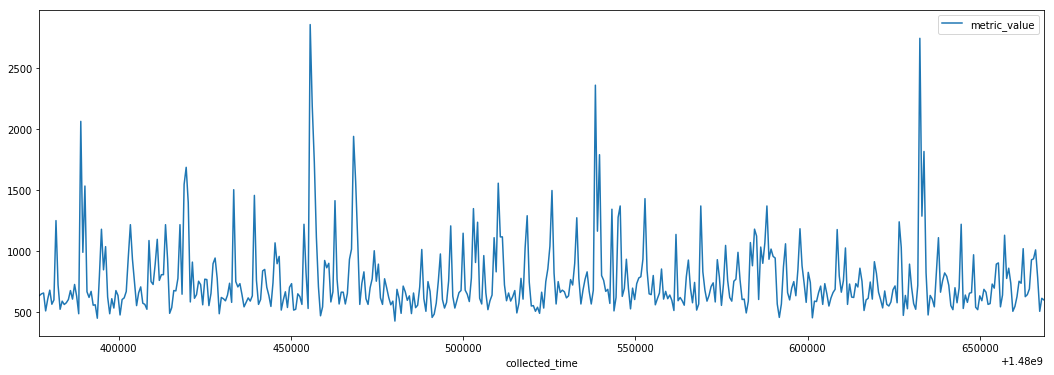

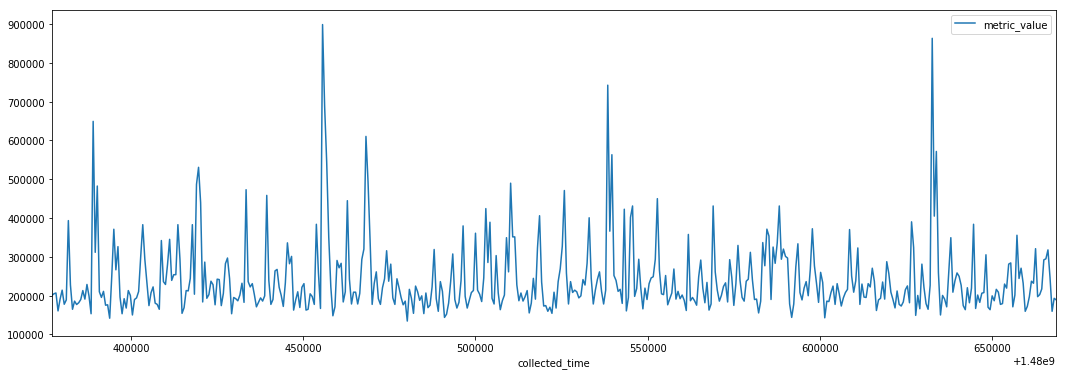

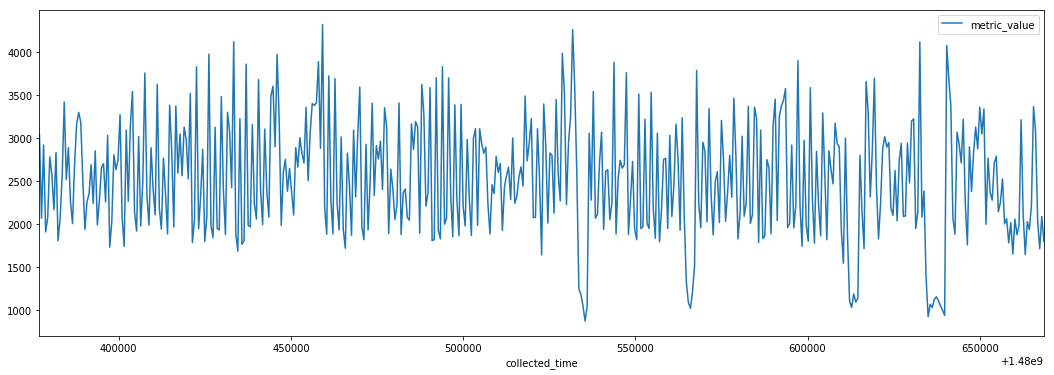

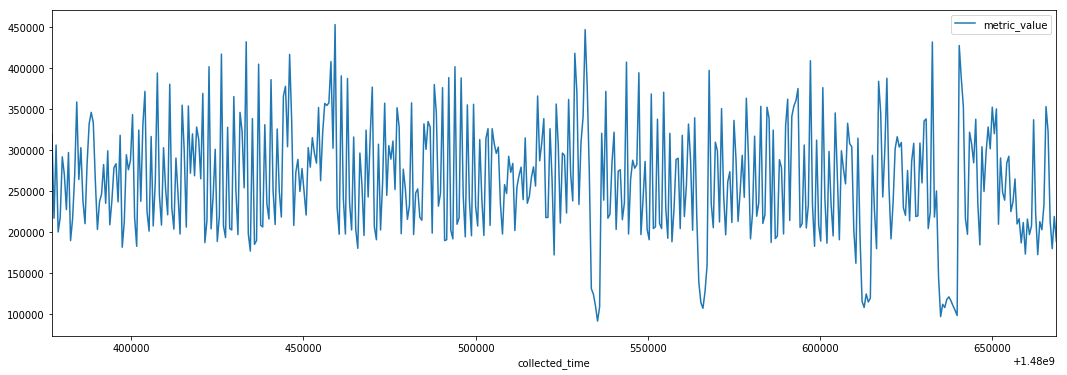

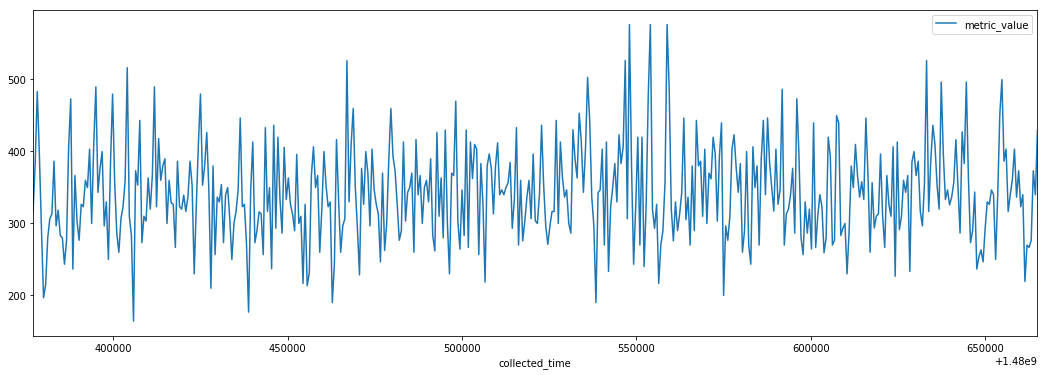

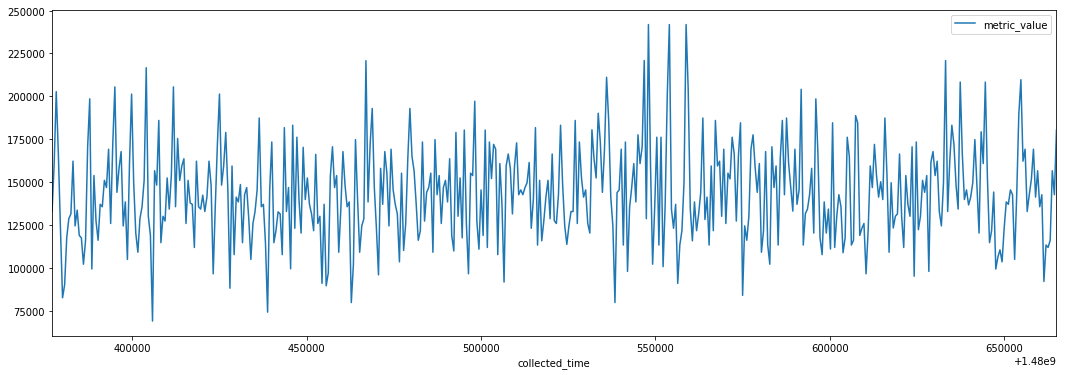

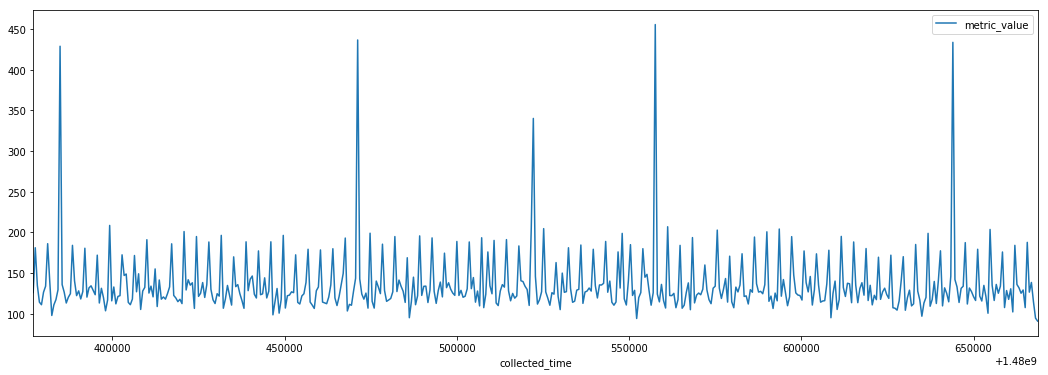

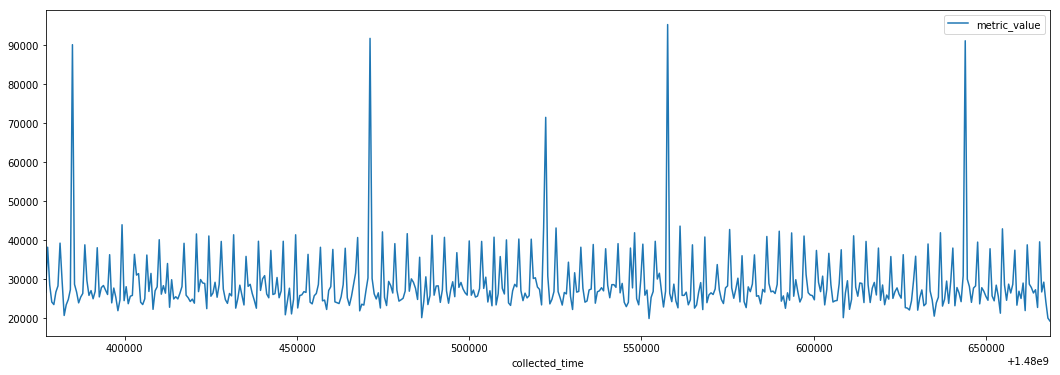

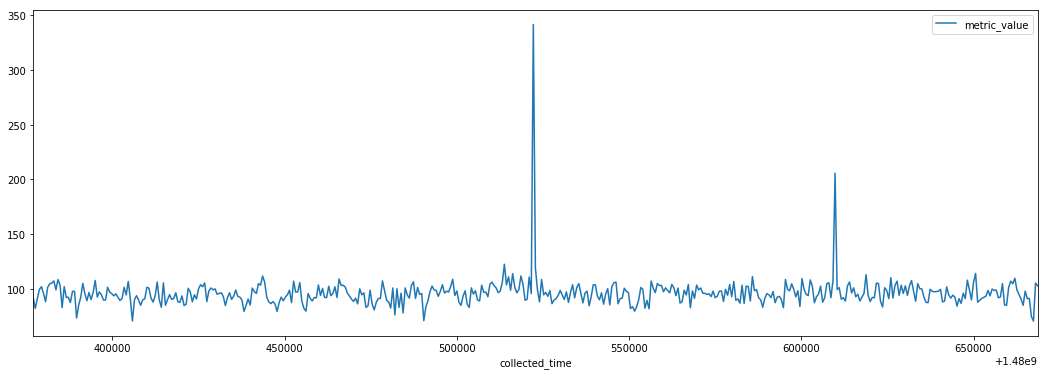

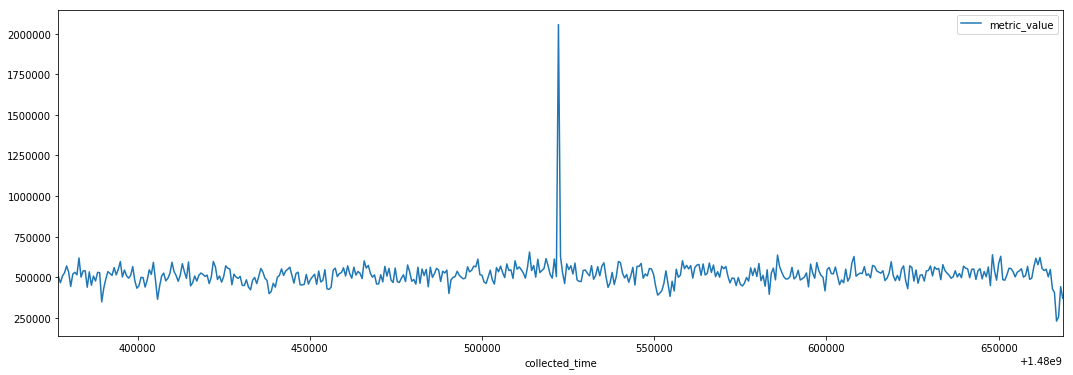

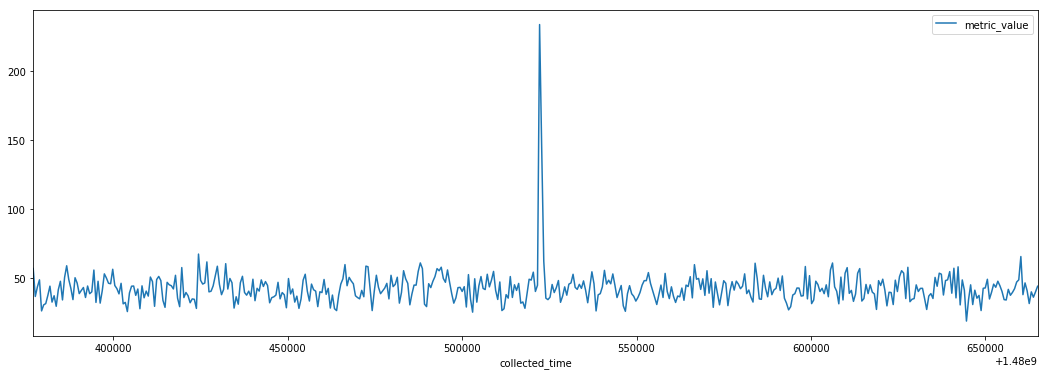

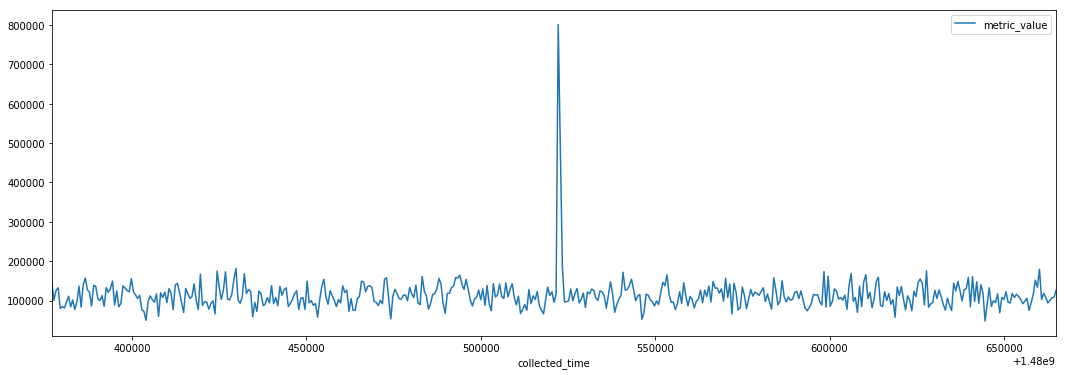

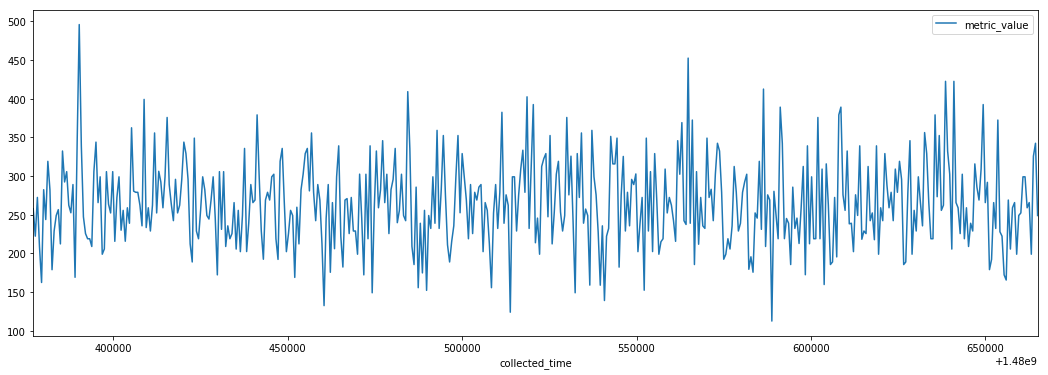

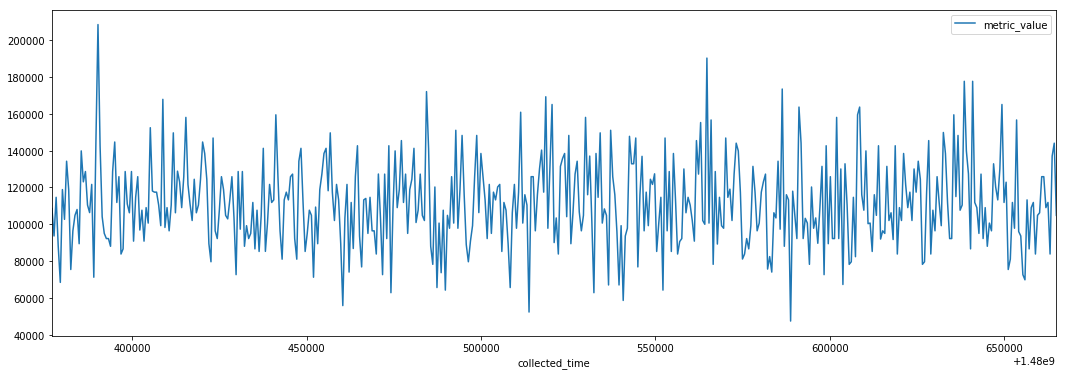

In [27]:
for ind, (name, group) in enumerate(vms_g):
    group[group['metric_name'] == 'mem.usage.absolute.percent'].sort_values('collected_time').plot(x= 'collected_time', y='metric_value')
    group[group['metric_name'] == 'mem.active.absolute.kiloBytes'].sort_values('collected_time').plot(x= 'collected_time', y='metric_value')
    
    if ind > 5:
        break

In [28]:
vm_demand = vm_demand.reset_index(drop=True)

In [29]:
vm_demand.rename(columns={'entity_id': 'key', 'collected_time': 'time', 'metric_value': 'demand'}, inplace=True)

In [30]:
time = vm_demand['time'].unique()
time.sort()
time_to_ind = {}
for ind, time in enumerate(time):
    time_to_ind[time] = ind
vm_demand['time'] = vm_demand['time'].map(lambda x: time_to_ind[x])
vm_demand.head()
vm_demand['demand']*=1.5
vm_demand.head()

key        demand  time
0  421cd40b-35de-a7c9-2a71-3964b34f84e0  4.575578e+05     0
1  4216c08e-bdae-a35f-06bf-0f437d47cf84  3.869242e+06     0
2  421cf118-1e2a-4ae0-cbe9-c79526418fc7  6.039786e+05     0
3  42162788-d12c-6f5a-e8b4-b6c6d00818b4  8.080541e+05     0
4  42162788-d12c-6f5a-e8b4-b6c6d00818b4  8.784428e+05     1

In [31]:
import ortools.linear_solver.pywraplp as pl
import math
import pandas as pd
import random
import string


# m=pl.Solver("vmware",pl.Solver.CBC_MIXED_INTEGER_PROGRAMMING)
m=pl.Solver("vmware",pl.Solver.BOP_INTEGER_PROGRAMMING)

time_horizon=50
time_index=range(time_horizon)
num_hosts=16
host_index=range(num_hosts)
import numpy as np

def generate_task(min_start_time=0,mean_duration=5 ,max_end_time=time_horizon,
                  distribution_demand=lambda x:np.random.uniform(0,5,size=x)):
    task_begin=np.random.uniform(min_start_time,
                                 math.floor(max_end_time-(max_end_time-min_start_time)/2))
    task_begin=int(math.floor(task_begin))
    task_end=int(np.random.uniform(
        task_begin+1,task_begin+1+mean_duration*2
    ))

    task_end=int(math.floor(max(task_end,max_end_time)))
    task_len=int(task_end-task_begin+1)
    distribution_demand=distribution_demand(task_len)
    time_ind=range(task_begin,task_end+1)
    # print len(time_ind)
    # print len(distribution_demand)
    key=''.join(random.choice(string.ascii_uppercase + string.digits) for _ in range(6))

    return pd.DataFrame({'key':key,'time':time_ind,'demand':distribution_demand})
    # return {'start':task_begin,'end':task_end,'demand':list(distribution_demand)}


# print generate_task(0,10,3)
#

import numpy as np
import pandas as pd
import itertools

def cartesian(df1, df2):
    rows = itertools.product(df1.iterrows(), df2.iterrows())

    df = pd.DataFrame(left.append(right) for (_, left), (_, right) in rows)
    return df.reset_index(drop=True)

# m=mp.Model("vmware")
machines=pd.DataFrame({'host':host_index})
times=pd.DataFrame({'time':time_index})
pd_uit=cartesian(machines,times)

# uit=[m.IntVar(0,1,str(i)+'safdsad') for i in pd_uit.index.tolist()]
uit=[m.BoolVar(str(i)+'safdsad') for i in pd_uit.index.tolist()]

pd_uit['uit']=uit
# swtich-on constraints
# swit=m.BoolVar(pd_uit.index.tolist(),0,1,
#                       pd_uit.apply(lambda x:'sw'+str(x['host'])+"_"+str(x['time']),axis=1)
#                        )

swit=[m.BoolVar('') for _ in pd_uit.index.tolist()]
pd_uit['swit']=swit

unique_times=pd_uit['time'].drop_duplicates().tolist()
times_after_first=unique_times[2:]
grp0=pd_uit.groupby(['host'])
if True:
    for _, grp in grp0:
        kk=grp.sort_values('time')
        for l in range(3,kk.shape[0]):
            m.Add(
                kk.iloc[l]['uit']<=kk.iloc[l-1]['uit']+kk.iloc[l-3]['swit']
        )


x_obj=m.Sum(pd_uit['uit'].tolist())
m.Minimize(x_obj)

num_tasks=50
generated_tasks=[generate_task() for _ in range(num_tasks)]
generated_tasks=pd.concat(generated_tasks)
generated_tasks = generated_tasks#vm_demand[:1]
generated_tasks.head()
generated_tasks.key.unique()
generated_tasks = vm_demand
generated_tasks = generated_tasks[generated_tasks['time'] < 40 ]
generated_tasks.shape

(35679, 3)

In [32]:
#generated_tasks = vm_demand
# print generated_tasks

moo=pd_uit.merge(generated_tasks,how='inner',left_on='time',right_on="time")
# moo['xijt']=m.binary_var_list(list(moo.index),0,1,moo.apply(lambda x:str("u")+"_"+str(x['host'])+"_"+str(x['time'])+"_"+str(x['key']),axis=1))
# moo['xijt']=[m.IntVar(0,1,'') for i in list(moo.index)]
moo['xijt']=[m.BoolVar('') for i in list(moo.index)]

print moo.shape

# add capacity constraints
host_capacity=150000000
grpby1=moo.groupby(['host',"time"])
for nm,grp in grpby1:
    #print nm
    #print grp
    expr=grp['uit'].tolist()[0]
    #print expr
    m.Add(expr*host_capacity>=m.Sum(l*k for k,l in zip(grp['xijt'].tolist(),grp['demand'].tolist())))

# add assignment constraints
grpby2=moo.groupby(['key',"time"])
for _,grp in grpby2:
    m.Add(m.Sum(grp['xijt'].tolist())==1)

m.set_time_limit(100000)
m.EnableOutput()
kk=m.Solve()
print m.Objective().Value()

(570864, 7)
373.0


In [33]:
moo['res_assignment'] = moo['xijt'].apply(lambda x: x.solution_value())
moo['host_on'] = moo['uit'].apply(lambda x: x.solution_value())

In [34]:
moo.head()

host  time        uit              swit  \
0     0     0   0safdsad  auto_v_000000800   
1     0     0   0safdsad  auto_v_000000800   
2     0     0   0safdsad  auto_v_000000800   
3     0     0   0safdsad  auto_v_000000800   
4     1     0  50safdsad  auto_v_000000850   

                                    key        demand              xijt  \
0  421cd40b-35de-a7c9-2a71-3964b34f84e0  4.575578e+05  auto_v_000001600   
1  4216c08e-bdae-a35f-06bf-0f437d47cf84  3.869242e+06  auto_v_000001601   
2  421cf118-1e2a-4ae0-cbe9-c79526418fc7  6.039786e+05  auto_v_000001602   
3  42162788-d12c-6f5a-e8b4-b6c6d00818b4  8.080541e+05  auto_v_000001603   
4  421cd40b-35de-a7c9-2a71-3964b34f84e0  4.575578e+05  auto_v_000001604   

   res_assignment  host_on  
0             0.0      0.0  
1             0.0      0.0  
2             0.0      0.0  
3             0.0      0.0  
4             0.0      0.0

In [35]:
pd_uit['uit'].apply(lambda x: x.solution_value()).sum()

373.0

In [36]:
vm_memory.metric_value.mean()

788683.93613460183

In [37]:
g = power_stats.groupby(['esx__fk', 'collected_time'])

In [38]:
vm_memory.head()

entity_id     entity_type  metric_value  \
4660   421cd40b-35de-a7c9-2a71-3964b34f84e0  VirtualMachine  3.050385e+05   
14273  4216c08e-bdae-a35f-06bf-0f437d47cf84  VirtualMachine  2.579495e+06   
9715   421cf118-1e2a-4ae0-cbe9-c79526418fc7  VirtualMachine  4.026524e+05   
14412  42162788-d12c-6f5a-e8b4-b6c6d00818b4  VirtualMachine  5.387028e+05   
8037   42162788-d12c-6f5a-e8b4-b6c6d00818b4  VirtualMachine  5.856285e+05   

                         metric_name aggregation_type  aggregation_period  \
4660   mem.active.absolute.kiloBytes              avg                 600   
14273  mem.active.absolute.kiloBytes              avg                 600   
9715   mem.active.absolute.kiloBytes              avg                 600   
14412  mem.active.absolute.kiloBytes              avg                 600   
8037   mem.active.absolute.kiloBytes              avg                 600   

       collected_time  
4660       1480372800  
14273      1480372800  
9715       1480372800  
14412      1480372800  
8037       1480373400

In [39]:
res = moo[['host', 'time', 'key', 'demand', 'res_assignment', 'host_on']]

In [40]:
res.head()

host  time                                   key        demand  \
0     0     0  421cd40b-35de-a7c9-2a71-3964b34f84e0  4.575578e+05   
1     0     0  4216c08e-bdae-a35f-06bf-0f437d47cf84  3.869242e+06   
2     0     0  421cf118-1e2a-4ae0-cbe9-c79526418fc7  6.039786e+05   
3     0     0  42162788-d12c-6f5a-e8b4-b6c6d00818b4  8.080541e+05   
4     1     0  421cd40b-35de-a7c9-2a71-3964b34f84e0  4.575578e+05   

   res_assignment  host_on  
0             0.0      0.0  
1             0.0      0.0  
2             0.0      0.0  
3             0.0      0.0  
4             0.0      0.0

In [41]:
res.to_csv('./optimization_output.csv', index=False)

In [42]:
res.head()

host  time                                   key        demand  \
0     0     0  421cd40b-35de-a7c9-2a71-3964b34f84e0  4.575578e+05   
1     0     0  4216c08e-bdae-a35f-06bf-0f437d47cf84  3.869242e+06   
2     0     0  421cf118-1e2a-4ae0-cbe9-c79526418fc7  6.039786e+05   
3     0     0  42162788-d12c-6f5a-e8b4-b6c6d00818b4  8.080541e+05   
4     1     0  421cd40b-35de-a7c9-2a71-3964b34f84e0  4.575578e+05   

   res_assignment  host_on  
0             0.0      0.0  
1             0.0      0.0  
2             0.0      0.0  
3             0.0      0.0  
4             0.0      0.0

In [43]:
res.groupby(['key', 'time']).sum()

host        demand  res_assignment  \
key                                  time                                       
4200ef3d-f8fa-5ab3-3e8f-4b18a1ade8e8 7      120  4.801594e+06             1.0   
                                     8      120  4.907277e+06             1.0   
                                     9      120  4.957610e+06             1.0   
                                     10     120  3.850320e+06             1.0   
                                     11     120  4.580118e+06             1.0   
                                     12     120  5.133766e+06             1.0   
                                     13     120  4.261901e+06             1.0   
                                     14     120  4.529786e+06             1.0   
                                     15     120  9.437136e+06             1.0   
                                     16     120  5.460928e+06             1.0   
                                     17     120  3.950979e+06             1.0   
                                     18     120  4.454285e+06             1.0   
                                     19     120  4.246671e+06             1.0   
                                     20     120  4.353626e+06             1.0   
                                     21     120  4.554986e+06             1.0   
                                     22     120  5.108608e+06             1.0   
                                     23     120  4.580122e+06             1.0   
                                     24     120  5.486090e+06             1.0   
                                     25     120  4.764076e+06             1.0   
                                     26     120  3.674157e+06             1.0   
                                     27     120  1.557761e+07             1.0   
                                     28     120  7.474189e+06             1.0   
                                     29     120  1.157622e+07             1.0   
                                     30     120  5.033094e+06             1.0   
                                     31     120  4.685995e+06             1.0   
                                     32     120  5.058278e+06             1.0   
                                     33     120  4.202637e+06             1.0   
                                     34     120  4.227792e+06             1.0   
                                     35     120  3.397347e+06             1.0   
                                     36     120  5.989405e+06             1.0   
...                                         ...           ...             ...   
564dc893-71f0-0d5f-b6c7-0581ffbb1deb 10     120  0.000000e+00             1.0   
                                     11     120  0.000000e+00             1.0   
                                     12     120  0.000000e+00             1.0   
                                     13     120  0.000000e+00             1.0   
                                     14     120  0.000000e+00             1.0   
                                     15     120  0.000000e+00             1.0   
                                     16     120  0.000000e+00             1.0   
                                     17     120  0.000000e+00             1.0   
                                     18     120  0.000000e+00             1.0   
                                     19     120  0.000000e+00             1.0   
                                     20     120  0.000000e+00             1.0   
                                     21     120  0.000000e+00             1.0   
                                     22     120  0.000000e+00             1.0   
                                     23     120  0.000000e+00             1.0   
                                     24     120  0.000000e+00             1.0   
                                     25     120  0.000000e+00             1.0   
                                     26     120  0.000000e+00             